# 1. Einleitung

In diesem Use Case analysieren wir einen umfangreichen Datensatz von eBay-Fahrzeuganzeigen, um Einblicke in den Gebrauchtwagenmarkt zu gewinnen. Unsere Aufgabe ist es, die Daten zu bereinigen, unplausible Einträge zu entfernen und so die Grundlage für eine valide Analyse zu schaffen. Durch die Exploration und Visualisierung der Daten erkennen wir Muster und Trends, die für Käufer und Verkäufer von Bedeutung sind. Ziel ist es, die Häufigkeiten von Marken und Modellen zu visualisieren und eine Preisprognose für die Fahrzeuge zu erstellen. Letztendlich möchten wir ein Prognosemodell entwickeln, das genaue Preisvorhersagen ermöglicht und somit den Markt effizienter gestaltet.

# 2. Importieren der benötigten Bibliotheken und Einrichten der globalen Variabeln

Um eine klare Übersicht über unsere Abhängigkeiten zu haben, beginnen wir mit dem Importieren aller erforderlichen Bibliotheken und einrichten der globalen Variablen. Dies stellt sicher, dass wir alles bereit haben, bevor wir mit dem Codieren beginnen.

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from unidecode import unidecode
import matplotlib.ticker as mtick
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [58]:
# # Setzt das Anzeigeformat für Fließkommazahlen auf zwei Dezimalstellen
pd.set_option('display.float_format', '{:.6f}'.format)

# Konfiguriert Pandas so, dass alle Spalten eines DataFrames bei der Ausgabe angezeigt werden, unabhängig von ihrer Anzahl.
pd.set_option('display.max_columns', None)

In [59]:
# Definiert eine globale Variable für den Dateipfad
FILE_PATH = 'cars_use_case.csv'
SUPPORT_DATA_PATH = '2023_car_dataset.csv'

# Stellt sicher, dass der Dateipfad absolut ist
ABS_FILE_PATH = os.path.abspath(FILE_PATH)
ABS_SUPPORT_DATA_PATH = os.path.abspath(SUPPORT_DATA_PATH)

# 3. Laden des Datensatzes

Jetzt laden wir den eBay-Fahrzeugdatensatz, um mit unserer Analyse zu beginnen.

In [60]:
# Verwendung von ABS_FILE_PATH zum Laden der Daten
car_data = pd.read_csv(ABS_FILE_PATH, sep=',', index_col=0)

In [61]:
car_data.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,150000,0,benzin,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,125000,5,diesel,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,125000,8,diesel,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,150000,6,benzin,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,90000,7,diesel,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Beschreibung der Datenspalten

- `dateCrawled`: Datum und Uhrzeit, wann der Crawler die Anzeige gefunden hat.
- `name`: Name des Fahrzeugs, beinhaltet Marke und Modell.
- `seller`: Art des Verkäufers - privat oder gewerblich (Händler).
- `offerType`: Typ des Angebots - Angebot (Verkauf) oder Gesuch (Kauf).
- `price`: Preis des Fahrzeugs in Euros. (Annahme basierend auf der Postleitzahlen; Bestätigung der Währung erforderlich)
- `abtest`: Feld für A/B-Tests, um die Qualität von eBay Kleinanzeigen zu verbessern - Control oder Test.
- `vehicleType`: Fahrzeugtyp wie Limousine, SUV etc.
- `yearOfRegistration`: Jahr, in dem das Fahrzeug erstmalig registriert wurde.
- `gearbox`: Getriebeart des Fahrzeugs - manuell oder automatisch.
- `powerPS`: Leistung des Fahrzeugs in PS.
- `kilometer`: Gefahrene Kilometer.
- `monthOfRegistration`: Monat, in dem das Fahrzeug erstmalig zugelassen wurde - 0 bis 12.
- `fuelType`: Kraftstofftyp, z.B. Benzin, Diesel.
- `notRepairedDamage`: Information über nicht reparierte Schäden am Fahrzeug.
- `dateCreated`: Datum, an dem die Anzeige auf eBay erstellt wurde.
- `nrOfPictures`: Anzahl der Bilder in der Fahrzeuganzeige.
- `postalCode`: Postleitzahl des Anbieters.
- `lastSeen`: Datum und Uhrzeit, wann die Anzeige zuletzt gesehen wurde.


# 4. Exploratorive Datenanalyse ( EDA )

Bevor wir mit der Modellierung beginnen, ist es sinnvoll, unseren Datensatz zu erkunden. Dies kann das Überprüfen auf fehlende Werte, das Visualisieren der Verteilungen von Variablen und das Verstehen der Beziehungen zwischen verschiedenen Variablen beinhalten. 

## Shape

In [62]:
# Anzahl der Zeilen und Spalten
nrows, ncols = car_data.shape
print(f'Zeilen: {nrows}')
print(f'Spalten: {ncols}')

Zeilen: 371528
Spalten: 18


## Data Informationen

In [63]:
# Informationen über die Daten
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 371528 entries, 0 to 371527
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  kilometer            371528 non-null  int64 
 11  monthOfRegistration  371528 non-null  int64 
 12  fuelType             338142 non-null  object
 13  notRepairedDamage    299468 non-null  object
 14  dateCreated          371528 non-null  object
 15  nrOfPictures         371528 non-null  i

## Beobachtungen zur Informationen

Der Datensatz umfasst 371.528 Einträge und 18 Spalten, was auf eine umfangreiche Sammlung von Fahrzeugdaten hindeutet. Es gibt eine Mischung aus numerischen (7 Spalten) und Objekt- bzw. Textdaten (11 Spalten), was auf eine Vielfalt an Informationen über jedes Fahrzeug hinweist.

- **Vollständige Daten**: Mehrere Spalten wie dateCrawled, name, seller, offerType, price, abtest, yearOfRegistration, powerPS, kilometer, monthOfRegistration, dateCreated, nrOfPictures, postalCode und lastSeen haben keine fehlenden Werte. Dies deutet auf eine hohe Datenqualität und Vollständigkeit in diesen Bereichen hin.
- **Fehlende Werte**: Die Spalten vehicleType, gearbox, fuelType und notRepairedDamage weisen fehlende Werte auf. Insbesondere notRepairedDamage hat eine signifikante Anzahl an fehlenden Daten, was bei der Analyse und Modellierung berücksichtigt werden muss. Es muss entschieden werden, ob die Zeilen wo fehlende Werte vorkommen entfernt werden, die Werte durch einen geeigneten Wert ersetzt werden sollen oder nichts gemacht wird.
- **Datenformatierung**: Spalten wie dateCrawled, dateCreated und lastSeen sind als Objekte formatiert, welche vermutlich auf einem Datumsformat konvertiert werden müssen.
- **Kategorische und Numerische Daten**: Der Mix aus kategorischen (wie seller, offerType, vehicleType) und numerischen Daten (wie price, yearOfRegistration) ermöglicht vielfältige Analysemöglichkeiten, von der Beschreibung der Fahrzeugtypen bis hin zur Preisbewertung.

## Statistische Informationen

In [64]:
# Statistische Kennzahlen der numerischen Spalten
car_data.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000
mean,17295.141865,2004.577997,115.549477,125618.688228,5.734445,0.000000,50820.667640
std,3587953.744411,92.866598,192.139578,40112.337051,3.712412,0.000000,25799.082470
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.000000,1067.000000
25%,1150.000000,1999.000000,70.000000,125000.000000,3.000000,0.000000,30459.000000
50%,2950.000000,2003.000000,105.000000,150000.000000,6.000000,0.000000,49610.000000
75%,7200.000000,2008.000000,150.000000,150000.000000,9.000000,0.000000,71546.000000
max,2147483647.000000,9999.000000,20000.000000,150000.000000,12.000000,0.000000,99998.000000


## Basierend auf den statistischen Daten des Fahrzeugdatensatzes, hier eine Analyse:
Analyse der statistischen Daten des Fahrzeugdatensatzes

- **Preis**: Der Durchschnittspreis der Fahrzeuge liegt bei 17295 CHF, aber die Standardabweichung ist mit ca. 3587953 CHF extrem hoch. Dies deutet auf eine große Streuung der Preise hin. Der Maximalwert von über 2 Milliarden Euros und der Minimalwert bei 0 Euros erscheint unrealistisch und weist auf Ausreißer oder fehlerhafte Daten hin.

- **Baujahr (yearOfRegistration)**: Die Fahrzeuge im Datensatz stammen durchschnittlich aus dem Jahr 2004, wobei die ältesten Fahrzeuge aus dem Jahr 1000 und die neuesten aus 9999 stammen, was offensichtlich fehlerhaft ist. Die meisten Fahrzeuge wurden zwischen 1999 und 2008 registriert.

- **Leistung (powerPS)**: Die durchschnittliche Leistung der Fahrzeuge beträgt etwa 116 PS, aber auch hier zeigt die hohe Standardabweichung und der Maximalwert von 20.000 PS mögliche Dateninkonsistenzen.

- **Kilometerstand**: Die Fahrzeuge haben im Durchschnitt ca. 125.619 Kilometer zurückgelegt. Der Median von 150.000 Kilometern deutet darauf hin, dass viele Fahrzeuge in diesem Bereich liegen.

- **Zulassungsmonat (monthOfRegistration)**: Die Verteilung der Monate scheint gleichmäßig zu sein, mit einem Durchschnitt von etwa 5,7, was knapp unterhalb des Mittelwerts von 6 (Juni) liegt.

- **Anzahl der Bilder (nrOfPictures)**: Interessanterweise hat kein Fahrzeug im Datensatz Bilder, was Fragen zur Datenvollständigkeit aufwirft.

- **Postleitzahl (postalCode)**: Die Postleitzahlen variieren erheblich, was auf eine breite geografische Verteilung der Fahrzeuge hindeutet.

Diese statistische Analyse zeigt einige Auffälligkeiten und potenzielle Fehler im Datensatz, insbesondere bei Preisen, Baujahren und der Leistung der Fahrzeuge. Es wird empfohlen, eine gründliche Datenbereinigung durchzuführen, um realistische und zuverlässige Analysen und Prognosen zu ermöglichen.

## Analyse spezifischer Spalten

### Seller & OfferType

In [65]:
car_data['seller'].value_counts()

seller
privat        371525
gewerblich         3
Name: count, dtype: int64

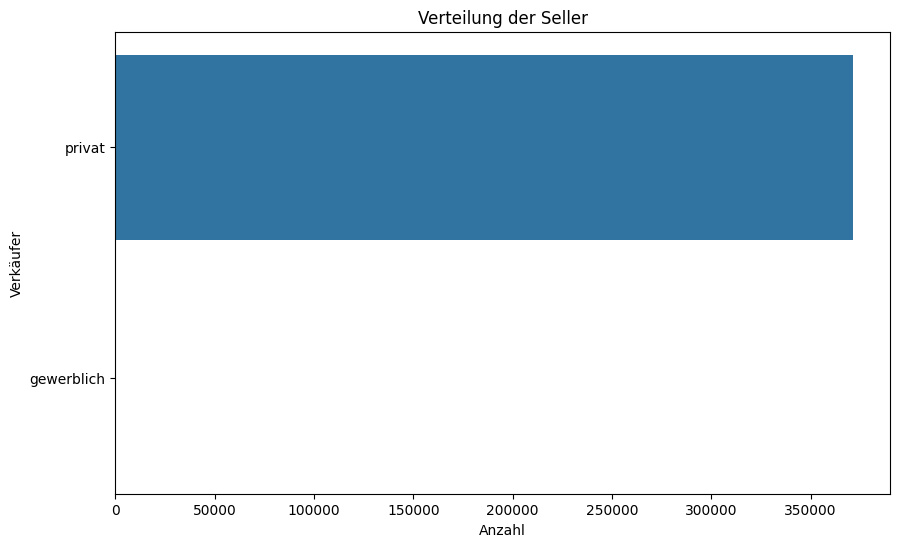

In [66]:
# Visualisierung der Verteilung der Zielvariable
plt.figure(figsize=(10, 6))
sns.countplot(car_data['seller'])
plt.ylabel('Verkäufer')
plt.xlabel('Anzahl')
plt.title('Verteilung der Seller')
plt.show()

In [67]:
car_data['offerType'].value_counts()

offerType
Angebot    371516
Gesuch         12
Name: count, dtype: int64

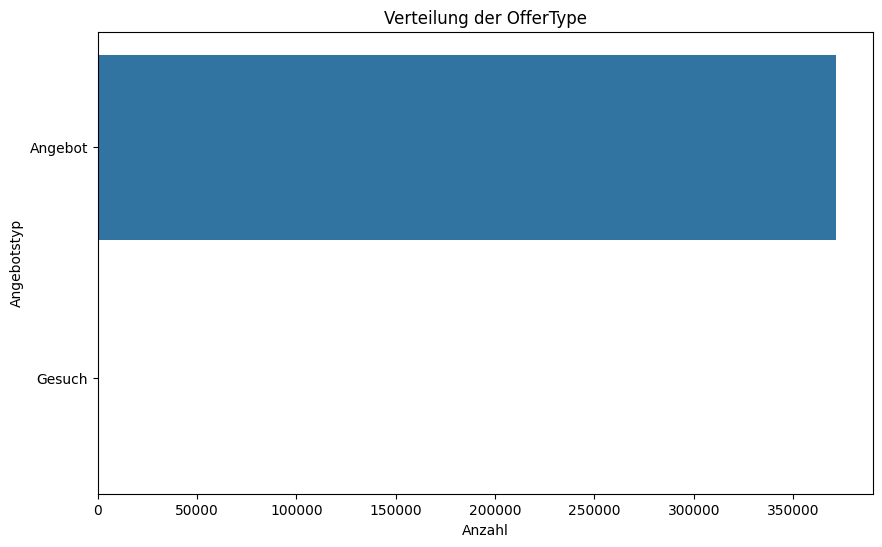

In [68]:
# Visualisierung der Verteilung der Zielvariable
plt.figure(figsize=(10, 6))
sns.countplot(car_data['offerType'])
plt.ylabel('Angebotstyp')
plt.xlabel('Anzahl')
plt.title('Verteilung der OfferType')
plt.show()

- Man kann hier sehen, dass die Verkäufer (seller) und Angebote (offerType) nur einen Wert haben, was bedeutet, dass alle Fahrzeuge von privaten Verkäufern angeboten werden. Dies ist eine wichtige Erkenntnis, da beide gute Kandidaten sind um entfernt zu werden, da sie keine zusätzlichen Informationen enthalten.

### Kilometer

In [69]:
car_data['kilometer'].value_counts()

kilometer
150000    240797
125000     38067
100000     15920
90000      12523
80000      11053
70000       9773
60000       8669
50000       7615
5000        7069
40000       6376
30000       6041
20000       5676
10000       1949
Name: count, dtype: int64

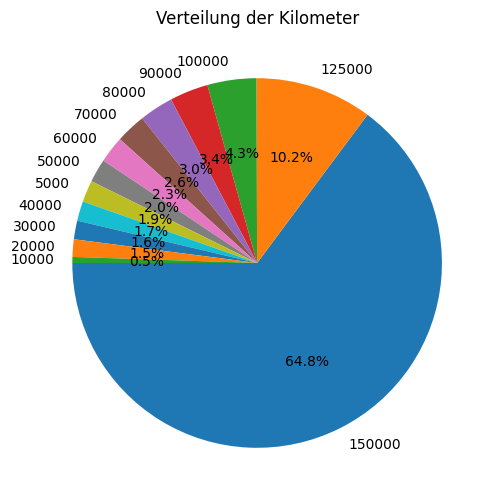

In [70]:
# Visualisierung der Verteilung der Zielvariable
plt.figure(figsize=(10, 6))
plt.pie(car_data['kilometer'].value_counts(), labels=car_data['kilometer'].value_counts().index, autopct='%1.1f%%', startangle=180)
plt.title('Verteilung der Kilometer')
plt.show()

In [71]:
car_data['kilometer'].nunique()

13

- Kilometer Spalte hat nur 13 distinkte Werte, was darauf hindeutet, dass die Daten durch Rundung oder Schätzung gesammelt wurden. 

In [72]:
(car_data['kilometer'] > 90000).sum() / nrows * 100

79.34368338321741

In [73]:
(car_data['kilometer'] == 150000).sum() / nrows * 100

64.81261170086778

- Mehr als 60% der Autos haben 150000km auf dem Tacho und ungefähr 80% haben mehr als 90000km auf dem Tacho. Dies macht Sinn, da die meisten Autos gebraucht sind und es scheinen keine Outliers zu geben.

### Price

In [74]:
car_data[car_data['price'].between(0.1, 20000)]

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,150000,0,benzin,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,125000,5,diesel,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,125000,8,diesel,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,150000,6,benzin,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,90000,7,diesel,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371521,2016-03-27 20:36:20,Opel_Zafira_1.6_Elegance_TÜV_12/16,privat,Angebot,1150,control,bus,2000,manuell,0,150000,3,benzin,nein,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
371523,2016-03-14 17:48:27,Suche_t4___vito_ab_6_sitze,privat,Angebot,2200,test,NaN,2005,NaN,0,20000,1,NaN,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
371524,2016-03-05 19:56:21,Smart_smart_leistungssteigerung_100ps,privat,Angebot,1199,test,cabrio,2000,automatik,101,125000,3,benzin,nein,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
371525,2016-03-19 18:57:12,Volkswagen_Multivan_T4_TDI_7DC_UY2,privat,Angebot,9200,test,bus,1996,manuell,102,150000,3,diesel,nein,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [75]:
car_data[car_data['price'].between(300000, 500000)].sort_values(by='price')

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
321966,2016-03-10 16:38:33,Porsche_991_GT3_RS_Sonderfarbe,privat,Angebot,300000,control,coupe,2016,automatik,500,5000,3,NaN,nein,2016-03-10 00:00:00,0,48165,2016-03-16 03:17:40
105193,2016-03-30 14:49:32,One_too_shui_fooooo,privat,Angebot,323223,control,coupe,2010,manuell,0,5000,4,hybrid,NaN,2016-03-30 00:00:00,0,14532,2016-04-07 05:44:31
82649,2016-03-30 08:37:24,Rolls_Royce_Phantom_Drophead_Coupe,privat,Angebot,345000,control,cabrio,2012,automatik,460,20000,8,benzin,nein,2016-03-30 00:00:00,0,73525,2016-04-07 00:16:26
132727,2016-03-11 20:57:38,Porsche_911_993_TURBO_WLS_1_NEUWAGENZUSTAND,privat,Angebot,349000,control,coupe,1998,manuell,430,20000,4,benzin,nein,2016-03-11 00:00:00,0,70191,2016-03-29 19:47:56
56490,2016-03-27 18:37:37,Porsche_991,privat,Angebot,350000,control,coupe,2016,manuell,500,5000,3,benzin,nein,2016-03-27 00:00:00,0,70499,2016-03-27 18:37:37
108590,2016-03-21 22:37:54,Porsche_911_R,privat,Angebot,350000,control,NaN,2015,NaN,0,5000,0,NaN,NaN,2016-03-21 00:00:00,0,55626,2016-03-22 00:42:10
330148,2016-04-04 11:06:24,Mercedes_Benz_C_63_AMG_7G_TRONIC,privat,Angebot,350000,control,limousine,2009,automatik,457,100000,3,benzin,nein,2016-04-04 00:00:00,0,65479,2016-04-04 17:23:22
120460,2016-03-14 10:44:51,Andere_ISO_Grifo,privat,Angebot,350000,control,cabrio,1967,manuell,300,60000,5,benzin,nein,2016-03-14 00:00:00,0,40217,2016-03-15 23:47:09
336623,2016-03-17 09:49:55,Mercedes_Benz_SLR_McLaren_Roadster,privat,Angebot,368000,test,cabrio,2010,automatik,625,30000,3,benzin,nein,2016-03-17 00:00:00,0,46147,2016-03-17 09:49:55
168786,2016-04-02 23:53:46,Ferrari_512_BBi,privat,Angebot,370000,test,coupe,1984,manuell,340,20000,8,benzin,nein,2016-04-02 00:00:00,0,28355,2016-04-03 06:40:54


In [76]:
car_data.loc[car_data['price'] > 400000, ['name', 'price']] 

,name,price
1846,BMW_M1_Museumsfahrzeug_Neuwagenzustand_Glossy_...,579000
10649,Porsche_996_GT2_MK2_Clubsport,420000
14663,Tausch_moeglich_Polo_vw_n9,11111111
16889,Ford_Mondeo_Kombi_TÜV_abgelaufen,1000000
20143,Porsche_911R_Einer_von_911,1250000
...,...,...
364171,Ferrari_FXX,3890000
365461,BMW_M1_mit_4900_Km_Neuwagenzustand_Glossy_Orange,599000
366653,BMW_E36_Cabrio_tausch_gegen_ein_Opel_Insignia,99999999
366861,Ferrari_FXX__unfallfrei__perfekter_Zustand,3895000


- Klare Outliers wie 0 oder 99999999, die müssen entfernt werden. Es gibt aber eigene Zeilen wo der Preis Sinn machen können wie bei der Ferrari FXX. Es bräuchte also eine spezifische Analyse um rauszufinden welche Zeilen entfernt werden müssen. Vielleicht ist es einfacher die Zeilen zu behalten, die einen Preis haben der stark unter 400000 liegt.

<Axes: xlabel='price'>

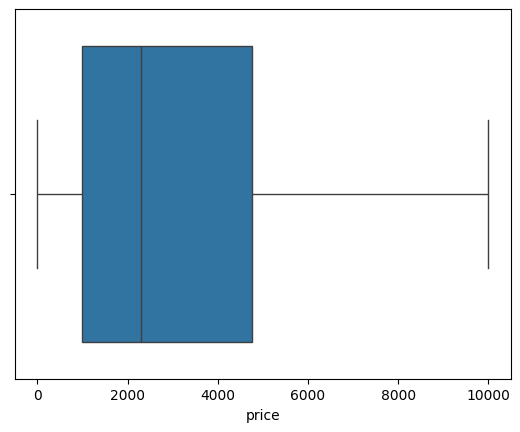

In [77]:
# Price visualisieren mit Seaborn Boxplot (ohne Ausreißer)
sns.boxplot(data=car_data[car_data['price'].between(0.01, 10000)], x='price')


## Date Columns: dateCrawled, dateCreated, lastSeen, Year of Registration, Month of Registration

In [78]:
# Wichtige Daten
FIRST_CAR_REGISTRATION_DATE_GERMANY = 1906

<Axes: xlabel='monthOfRegistration'>

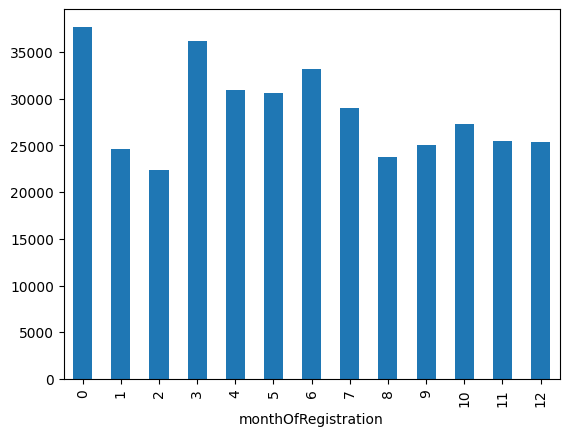

In [79]:
car_data['monthOfRegistration'].value_counts().sort_index().plot(kind='bar')

- Monat 0 ist ein Fehler und muss verarbeitet werden. Es könnten Typos vorgekommen sein oder "0" bezeichnet ein unbekanntes Datum.

In [80]:
car_data[['dateCrawled', 'dateCreated', 'lastSeen']].head()

,dateCrawled,dateCreated,lastSeen
0,2016-03-24 11:52:17,2016-03-24 00:00:00,2016-04-07 03:16:57
1,2016-03-24 10:58:45,2016-03-24 00:00:00,2016-04-07 01:46:50
2,2016-03-14 12:52:21,2016-03-14 00:00:00,2016-04-05 12:47:46
3,2016-03-17 16:54:04,2016-03-17 00:00:00,2016-03-17 17:40:17
4,2016-03-31 17:25:20,2016-03-31 00:00:00,2016-04-06 10:17:21


In [81]:
car_data[['dateCrawled', 'dateCreated', 'lastSeen']] = car_data[['dateCrawled', 'dateCreated', 'lastSeen']].apply(pd.to_datetime)

In [82]:
car_data[['dateCrawled', 'dateCreated', 'lastSeen', 'yearOfRegistration', 'monthOfRegistration']].describe()

,dateCrawled,dateCreated,lastSeen,yearOfRegistration,monthOfRegistration
count,371528,371528,371528,371528.000000,371528.000000
mean,2016-03-21 13:30:31.202717184,2016-03-20 19:42:51.495015168,2016-03-30 03:37:50.548152832,2004.577997,5.734445
min,2016-03-05 14:06:22,2014-03-10 00:00:00,2016-03-05 14:15:08,1000.000000,0.000000
25%,2016-03-13 12:51:46.500000,2016-03-13 00:00:00,2016-03-23 11:32:10.500000,1999.000000,3.000000
50%,2016-03-21 18:36:22,2016-03-21 00:00:00,2016-04-03 23:17:15,2003.000000,6.000000
75%,2016-03-29 14:49:31.249999872,2016-03-29 00:00:00,2016-04-06 10:45:02,2008.000000,9.000000
max,2016-04-07 14:36:58,2016-04-07 00:00:00,2016-04-07 14:58:51,9999.000000,12.000000
std,NaN,NaN,NaN,92.866598,3.712412


In [83]:
# Wichtige Daten
YEAR_OF_DATA_CRAWLED = 2016

- Autos können nur zwischen 1906 und 2016 registriert worden sein, da Autoregistrationen erst ab 1906 existieren und die Daten aus 2016 stammen.

In [84]:
car_data['dateCreated'].dt.time.value_counts(normalize=True).head()

dateCreated
00:00:00   1.000000
Name: proportion, dtype: float64

- Alle Anzeigen wurden um Mitternacht creeirt, was merkwürdig ist. Es ist wahrscheinlich, dass die Uhrzeit nicht verfügbar war und deshalb auf Mitternacht gesetzt wurde.

In [85]:
car_data.loc[car_data["yearOfRegistration"].between(1906, 2016), ["yearOfRegistration"]].value_counts(normalize=True).sort_index()

yearOfRegistration
1910                 0.000291
1911                 0.000003
1915                 0.000003
1919                 0.000003
1920                 0.000003
                       ...   
2012                 0.026397
2013                 0.017257
2014                 0.013459
2015                 0.008358
2016                 0.027633
Name: proportion, Length: 97, dtype: float64

- Man kann also Daten vor 1906 und nach 2016 entfernen, da sie nicht realistisch sind.

### PowerPS

In [86]:
# Stärkste PS Werte in 2023 is das Auto Lotus Evija mit 2039 PS und das Auto Benz Patent-Motorwagen Numemr 1 mit 0.75 PS
MAX_PS = 2039
MIN_PS = 0.75

<Axes: >

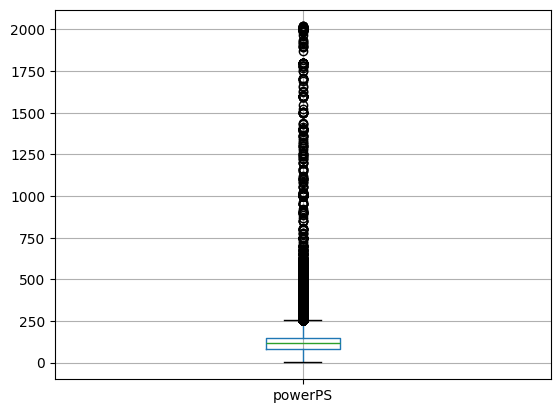

In [87]:
car_data[car_data['powerPS'].between(MIN_PS, MAX_PS)].boxplot(column='powerPS')

In [88]:
car_data.loc[~car_data['powerPS'].between(MIN_PS, MAX_PS), ['powerPS']].value_counts(normalize=True)

powerPS
0         0.997288
12512     0.000073
3500      0.000049
10522     0.000049
7511      0.000049
            ...   
6018      0.000024
6011      0.000024
6010      0.000024
6006      0.000024
20000     0.000024
Name: proportion, Length: 102, dtype: float64

In [89]:
car_data.loc[~car_data['powerPS'].between(MIN_PS, MAX_PS), ['powerPS']].count() / nrows * 100

powerPS   11.016935
dtype: float64

- der Prozentanteil der Autos mit einem unrealistischen PowerPS Wert unter den MIN_PS oder über den MAX_PS ist bei 11%. Das ist ein grosser Anteil und es ist wahrscheinlich, dass diese Werte falsch sind. Ein grosser Teil dieser Werte liegen aber bei 0 was einen falschen Antrag entsprechen könnte. Man könnte also diese Werte mit einem Median z.B. imputen oder löschen.

### Name

#### Process:
- **Einlesen der Support-Daten**: Zunächst wurden Support-Daten aus einer separaten CSV-Datei gelesen. Diese Daten enthielten Informationen über Automarken und Modelle.

- **Erstellung von Keyword-Listen**: Basierend auf den Support-Daten und manuellen Ergänzungen wurden Listen von Keywords für Automarken (brands) und Modelle (models) erstellt.

- **Mapping von Marken und Modellen**: Ein Mapping-Dataframe wurde erstellt, der Beziehungen zwischen Marken und ihren jeweiligen Modellen abbildet.

- **Normalisierung und Tokenisierung**: Die Einträge in der "name" Spalte wurden normalisiert (z.B. durch Umwandlung in Kleinbuchstaben und Entfernung von Sonderzeichen) und in einzelne Wörter (Tokens) aufgeteilt.

- **Brand- und Modell-Parsing-Funktion**: Es wurde eine Parsing-Funktion entwickelt, die aus den Tokenized-Namen die Marke und das Modell extrahiert. Dabei wurden einige gängige Marken und Modelle standardisiert und Sonderfälle behandelt.

- **Anwendung der Parsing-Funktion**: Die Parsing-Funktion wurde auf die gesamte "name" Spalte angewandt, um die Marken und Modelle in neuen Spalten im Datensatz zu speichern.

- **Überprüfung auf korrekte Zuordnung**: Es wurden Metriken eingeführt, um zu überprüfen, ob die Marke korrekt ist (nicht in der Keyword-Liste), ob das Modell korrekt ist (nicht in der Keyword-Liste) und ob das Mapping korrekt ist (Marke wird fälschlicherweise als Modell identifiziert).

- **Visualisierung der Top 10 Automarken**: Schließlich wurden die Daten visualisiert, um die Top 10 der Automarken und Modelle in Bezug auf ihre Häufigkeit darzustellen.


##### Support Daten einlesen

In [90]:
support_data = pd.read_csv(ABS_SUPPORT_DATA_PATH, sep=',')

In [91]:
support_data.head()

,Car Make,Car Model,Year,Body Type,Color Options,Fuel Type,Engine Size (L),Horsepower,Torque (Nm),Transmission Type,Acceleration (0-60 mph),Top Speed (mph),Mileage (MPG),Safety Features,Entertainment Features,Interior Features,Exterior Features,Price ($),Customer Ratings,Sales Figures (Units Sold)
0,Toyota,Camry,2022,Sedan,"White, Silver, Black",Gasoline,2.5,203,245,Automatic,7.9 seconds,135,31,"ABS, Airbags, Lane-Keeping Assist, Blind Spot...",8-inch Touchscreen Infotainment System,"Leather Seats, Power Driver's Seat, Dual-Zone...","LED Headlights, Alloy Wheels, Sunroof ...","28,500",4.5/5,"1,500"
1,Ford,F-150,2023,Truck,"Blue, Red, Gray",Gasoline,3.5,375,475,Automatic,6.1 seconds,145,23,"ABS, Airbags, Trailer Sway Control, Rear View...",12-inch SYNC 4 Infotainment System,"Cloth Seats, Power Windows, Keyless Entry ...","LED Taillights, Tow Hitch, Bed Liner ...","45,900",4.8/5,"2,200"
2,Honda,Civic,2023,Sedan,"Black, Blue, Silver",Gasoline,1.8,158,180,CVT,8.2 seconds,120,36,"ABS, Airbags, Lane Departure Warning, Rear Cr...",7-inch Display Audio System,"Cloth Seats, Bluetooth Connectivity, Push But...","LED Daytime Running Lights, Alloy Wheels ...","22,950",4.6/5,"2,800"
3,Chevrolet,Tahoe,2023,SUV,"Red, White, Gray",Gasoline,5.3,355,519,Automatic,7.1 seconds,130,19,"ABS, Airbags, Forward Collision Warning, Lane...",10.2-inch Infotainment System,"Leather Seats, Heated Front Seats, Third-Row ...","LED Headlights, Roof Rails, Power Liftgate ...","53,250",4.7/5,"1,000"
4,Tesla,Model 3,2023,Sedan,"Blue, Red, Silver",Electric,N/A,283 (est.),440 (est.),Automatic,5.2 seconds,140 (est.),125 (est.),"Enhanced Autopilot, Lane Departure Warning, A...",15.4-inch Infotainment Display,"Vegan Leather Seats, Heated Steering Wheel, P...","Panoramic Glass Roof, Power Trunk, Alloy Whee...","49,990",4.9/5,"4,500"


In [92]:
support_data[' Car Make '] = support_data[' Car Make '].str.strip().str.lower()
support_data[' Car Model   '] = support_data[' Car Model   '].str.strip().str.lower()

- "brands" und "models" keyword Listen creeiren

In [93]:
manual_brands = ['mercedes-benz', 'mercedes benz', 'mercedes', 'benz', 'bmw', 'audi', 'volkswagen', 'vw', 'skoda', 'fiat', 'ford', 'opel', 'porsche', 
'ferrari', 'lamborghini', 'lamborgini', 'lamborgini', 'citroen', 'renault', 'peugeot', 'suzuki', 'daewoo', 'daihatsu', 'toyota', 'hyundai', 'kia', 'mazda',
'seat', 'smart', 'mini', 'mitsubishi', 'nissan', 'subaru', 'volvo', 'alfa romeo', 'chrysler', 'chevrolet', 'dodge', 'jeep', 'hummer', 'jaguar', 'land rover', 'rover']
support_brands = support_data[" Car Make "].unique() 
brand_keywords = np.concatenate((manual_brands, support_brands))
nbrands = len(brand_keywords)
nbrands, brand_keywords

(64,
 array(['mercedes-benz', 'mercedes benz', 'mercedes', 'benz', 'bmw',
        'audi', 'volkswagen', 'vw', 'skoda', 'fiat', 'ford', 'opel',
        'porsche', 'ferrari', 'lamborghini', 'lamborgini', 'lamborgini',
        'citroen', 'renault', 'peugeot', 'suzuki', 'daewoo', 'daihatsu',
        'toyota', 'hyundai', 'kia', 'mazda', 'seat', 'smart', 'mini',
        'mitsubishi', 'nissan', 'subaru', 'volvo', 'alfa romeo',
        'chrysler', 'chevrolet', 'dodge', 'jeep', 'hummer', 'jaguar',
        'land rover', 'rover', 'toyota', 'ford', 'honda', 'chevrolet',
        'tesla', 'nissan', 'bmw', 'hyundai', 'audi', 'gmc', 'subaru',
        'mazda', 'kia', 'mercedes', 'jeep', 'volkswagen', 'volvo', 'lexus',
        'genesis', 'acura', 'infiniti'], dtype=object))

In [94]:
manual_models = ['golf', 'a3', 'a4', 'a6', '3er', '5er', '6er', '7er', '1er', '2er', 'c-klasse', 'e-klasse', 's-klasse', 'a-klasse', 'b-klasse', 'c-klasse']
support_keywords = support_data[" Car Model   "].unique()
model_keywords = np.concatenate((manual_models, support_keywords))
nmodels = len(model_keywords)
nmodels, model_keywords

(96,
 array(['golf', 'a3', 'a4', 'a6', '3er', '5er', '6er', '7er', '1er', '2er',
        'c-klasse', 'e-klasse', 's-klasse', 'a-klasse', 'b-klasse',
        'c-klasse', 'camry', 'f-150', 'civic', 'tahoe', 'model 3', 'rogue',
        'x5', 'sonata', 'mustang', 'rav4', 'a4', 'sierra', 'cr-v',
        'outback', 'camaro', 'escape', 'cx-5', 'sorento', 'c-class',
        'wrangler', 'jetta', 'xc60', 'forester', 'highlander', 'explorer',
        'corvette', 'expedition', 'tucson', 'yukon', 'q5', 'telluride',
        'glc-class', 'grand cherokee', 'taos', 'pathfinder', 'crosstrek',
        '4runner', 'edge', 'equinox', 'hr-v', 's-class', 'compass',
        'atlas', 'sentra', 'legacy', 'rx', '5 series', 'mazda6', 'tacoma',
        'q7', 'bronco', 'odyssey', 'sportage', 'bolt euv', 'prius',
        'acadia', 'nx', 'sienna', 'ascent', 'versa', 'trax', 'is',
        'ranger', 'tundra', 'carnival', 'frontier', 'venue', 'gv80', 'fit',
        'maverick', 'soul', 'a5', 'rogue sport', 'xc40', 'mx-5 m

- Mapping dataframe zwischen brands und models für zeilen wo es die Marke oder Modell nicht gibt

In [95]:
car_brand_model_mapping_df = support_data[[' Car Make ', ' Car Model   ']].copy()
car_brand_model_mapping_df = car_brand_model_mapping_df.drop_duplicates()
car_brand_model_mapping_df

,Car Make,Car Model
0,toyota,camry
1,ford,f-150
2,honda,civic
3,chevrolet,tahoe
4,tesla,model 3
...,...,...
148,lexus,es
151,hyundai,santa fe
152,acura,rdx
158,infiniti,qx50


In [96]:
car_brand_model_mapping = car_brand_model_mapping_df.groupby(' Car Make ')[' Car Model   '].apply(lambda x: x.values.tolist()).to_dict()

- Jetzt muss man durch die "cars_data" durchgehen und die Marke und Modell finden und in die entsprechende Spalte einfügen

In [97]:
# Parsing function
def normalize_and_tokenize(name):
    name_normalized = unidecode(name.lower()).replace('_', ' ')
    tokens = name_normalized.split()
    return tokens

def parse_brand_model(entry):
    parts = normalize_and_tokenize(entry)
    brand = parts[0]
    model = parts[1] if len(parts) > 1 else ""
    model = parts[2] if len(parts) > 2 and (model == 'benz' or model == "alfa") else model

    # Standardizing some common brands and mistakes
    if brand.lower() == "vw":
        brand = "volkswagen"
    elif brand.lower() == "mercedes":
        brand = "mercedes-benz"
    elif brand.lower() == "alfa":
        brand = "alfa romeo"
    elif brand.lower() == "golf":
        brand = "volkswagen"
        model = "golf"
    elif brand.lower() == "a5":
        brand = "audi"
        model = "a5"
    elif brand.lower() == "ka":
        brand = "ford"
        model = "ka"
    elif brand.lower() == "punto":
        brand = "fiat"
        model = "punto"
    elif brand.lower() == "polo":
        brand = "volkswagen"
        model = "polo"
    return brand, model


- Ich teste erstmal mit den ersten 1000 Zeilen, um schnell zu sehen ob es funktioniert

In [98]:
#subset of car_data
car_data = car_data # [:1000]

car_data['normalized_tokens'] = car_data['name'].apply(normalize_and_tokenize)
car_data['brand'], car_data['model'] = zip(*car_data['name'].apply(lambda x: parse_brand_model(x)))
car_data['model'] = car_data['model'].apply(lambda x: next_token_after_benz(x) if x == "unknown" else x)



Erste Metriken, um zu sehen ob meine Methode funktioniert. 
- "wrongBrand" = "ist die Marke nicht in der Liste der brand_keywords"
- "wrongModel" = "ist das Modell nicht in der Liste der model_keywords"
- "wrongMapping" = "ist der brand Wert eigentlich ein model Wert"

In [99]:
car_data['wrongBrand'] = car_data['brand'].apply(lambda x: x not in brand_keywords)
car_data['wrongModel'] = car_data['model'].apply(lambda x: x not in model_keywords)
car_data['wrongMapping'] = car_data['brand'].apply(lambda x: x in model_keywords)
car_data.loc[car_data["wrongBrand"], ['name', 'brand', 'model', 'normalized_tokens', 'wrongBrand', 'wrongModel', 'wrongMapping']]

,name,brand,model,normalized_tokens,wrongBrand,wrongModel,wrongMapping
23,Stadtflitzer,stadtflitzer,,[stadtflitzer],True,True,False
38,Abschleppwagen_Vw_LT_195.000_gruene_Plakette_T...,abschleppwagen,vw,"[abschleppwagen, vw, lt, 195.000, gruene, plak...",True,True,False
40,Suche_Opel_corsa_a_zu_verschenken,suche,opel,"[suche, opel, corsa, a, zu, verschenken]",True,True,False
41,E_500_Avantgarde_AMG_Ausstattung,e,500,"[e, 500, avantgarde, amg, ausstattung]",True,True,False
52,Verkaufe_meinen_kleinen_wegen_neu_Anschaffung,verkaufe,meinen,"[verkaufe, meinen, kleinen, wegen, neu, anscha...",True,True,False
...,...,...,...,...,...,...,...
371504,220_cdi_Benz,220,cdi,"[220, cdi, benz]",True,True,False
371507,Gepflegter_Audi_a4_2.0tdi_xenon_ahk_klima_sche...,gepflegter,audi,"[gepflegter, audi, a4, 2.0tdi, xenon, ahk, kli...",True,True,False
371509,LT_35_DIESEL_Gruene_Plakette....letzte_Gelegen...,lt,35,"[lt, 35, diesel, gruene, plakette....letzte, g...",True,True,False
371520,turbo_defekt,turbo,defekt,"[turbo, defekt]",True,True,False


In [100]:
car_data.loc[car_data["wrongBrand"], ['wrongBrand']].count() / nrows * 100

wrongBrand   14.752320
dtype: float64

In [101]:
car_data['wrongBrand'].value_counts(normalize=True)

wrongBrand
False   0.852477
True    0.147523
Name: proportion, dtype: float64

Es bleiben noch 14% der Werte, die schlecht parsiert oder nicht klar sagen, was die Marke ist. Es muss entschieden werden, ob man dies imputiert oder die Zeilen entfernt.

In [102]:
car_data.loc[car_data["wrongModel"], ['wrongBrand']].count() / nrows * 100

wrongBrand   84.796032
dtype: float64

In [103]:
car_data['wrongModel'].value_counts(normalize=True)

wrongModel
True    0.847960
False   0.152040
Name: proportion, dtype: float64

Das richtige Modell zu bekommen ist viel schwieriger wegen der Vielfalt der Modelle. Es bräuchte eine bessere Methode/ besseren Datasatz um die Modelle zu finden.

In [104]:
car_data['wrongMapping'].value_counts(normalize=True)

wrongMapping
False   0.994934
True    0.005066
Name: proportion, dtype: float64

- Man kann hier sehen, dass es viel mehr falsche Werte für die Modelle. Dies macht Sinn, weil es viel mehr Modelle als Marken gibt. Es ist also wahrscheinlicher, dass ein falsches Modell als eine falsche Marke angegeben wird. 
- Die "wrongMapping" Metrik könnte benutzt werden, um das Parsing zu verbessern. Es sind aber nur 2% der Fehler, also ist es nicht so wert es zu verbessern. 
- Verbesserungsmöglichkeiten könnten einen besserer Regex sein oder eine bessere Keyword Liste (Car Dataset).

In [105]:
car_data['brand'].value_counts(normalize=True).head(10)

brand
volkswagen      0.184422
bmw             0.096421
opel            0.090935
mercedes-benz   0.079808
audi            0.078979
ford            0.059686
renault         0.039491
peugeot         0.026100
fiat            0.023094
seat            0.017057
Name: proportion, dtype: float64

In [106]:
top_10_brands = car_data['brand'].value_counts().head(10).index

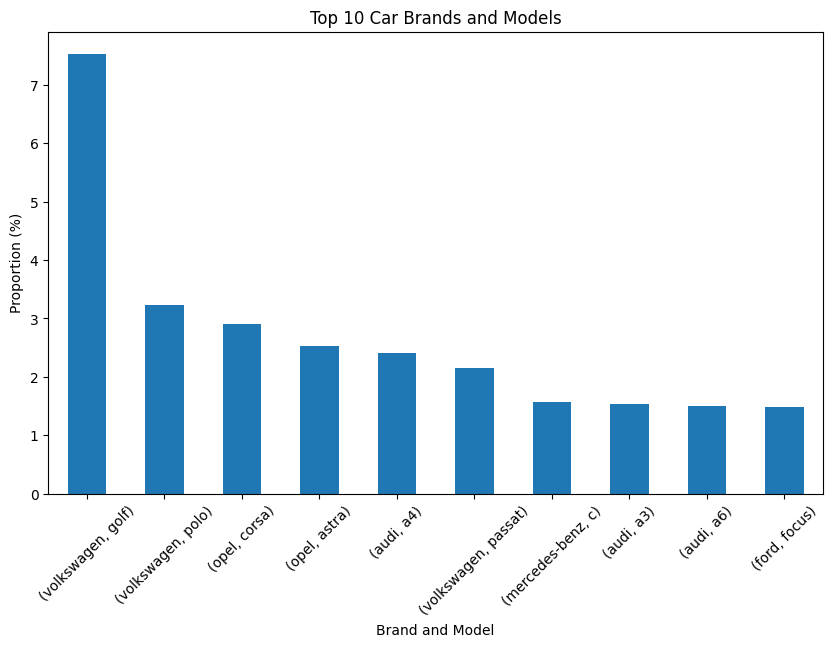

In [107]:
# Visualisierung der Top 10 Automarken
c = car_data[['brand', 'model']].value_counts(normalize=True).sort_values(ascending=False).head(10) * 100
# Plotting
plt.figure(figsize=(10, 6))
c.plot(kind='bar')
plt.title('Top 10 Car Brands and Models')
plt.xlabel('Brand and Model')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

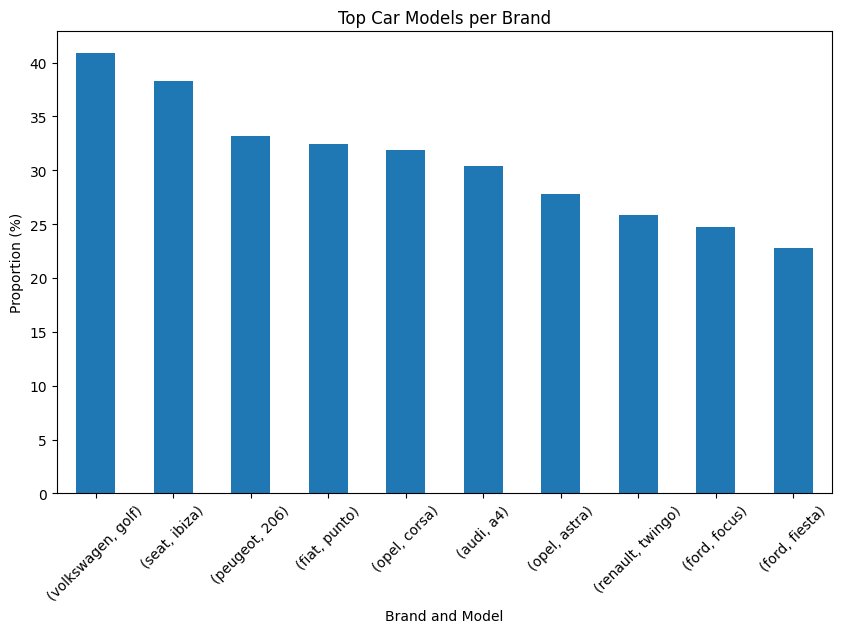

In [108]:
# Visualisierung der Modelle per Marke
c = car_data.groupby('brand')['model'].value_counts(normalize=True).loc[top_10_brands].sort_values(ascending=False).head(10) * 100

# Plotting
plt.figure(figsize=(10, 6))
c.plot(kind='bar')
plt.title('Top Car Models per Brand')
plt.xlabel('Brand and Model')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

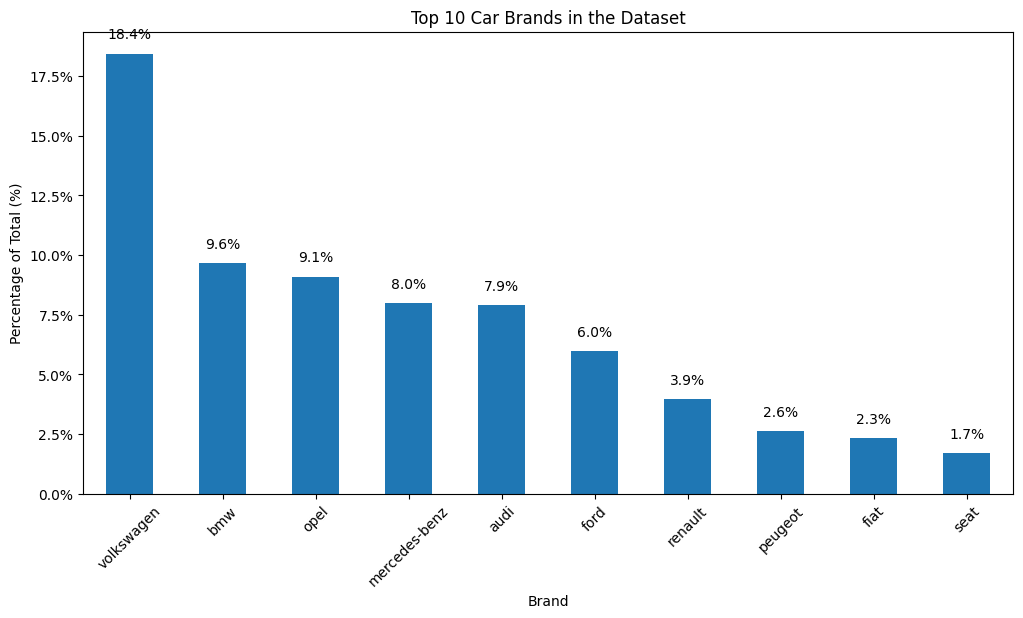

In [109]:
# Set the size of the plot
plt.figure(figsize=(12, 6))

# Plotting the bar chart
(car_data['brand'].value_counts(normalize=True).sort_values(ascending=False).head(10) * 100).plot(kind='bar')

# Formatting the Y-axis as percentage
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

# Adding title and axis labels
plt.title('Top 10 Car Brands in the Dataset')
plt.xlabel('Brand')
plt.ylabel('Percentage of Total (%)')

# Rotating X-axis labels for better readability
plt.xticks(rotation=45)

# Adding value labels on each bar
for i in plt.gca().patches:
    plt.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.5, f'{i.get_height():.1f}%', ha='center', va='bottom')

# Display the plot
plt.show()

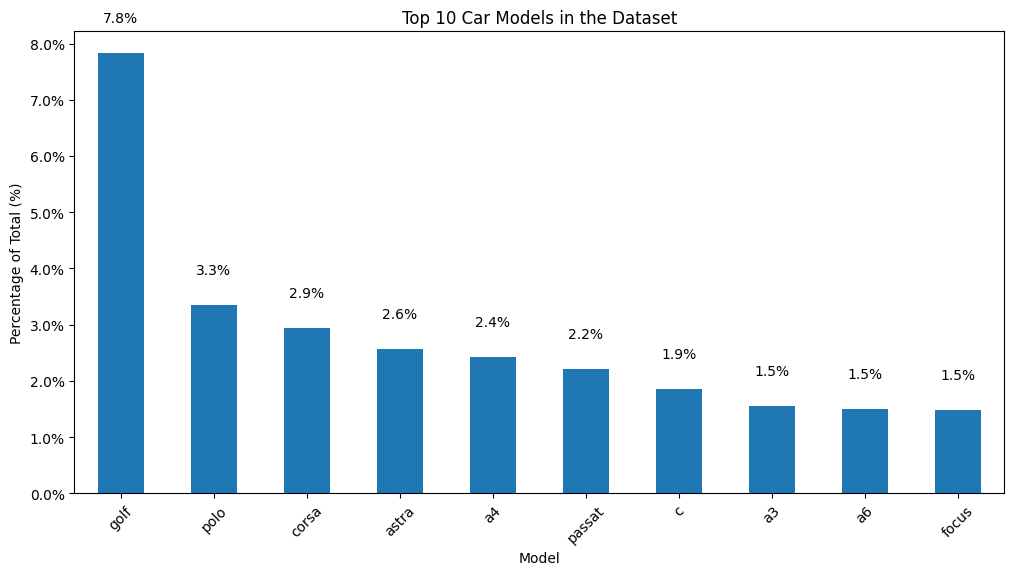

In [110]:
# Set the size of the plot
plt.figure(figsize=(12, 6))

# Plotting the bar chart
(car_data['model'].value_counts(normalize=True).sort_values(ascending=False).head(10) * 100).plot(kind='bar')

# Formatting the Y-axis as percentage
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

# Adding title and axis labels
plt.title('Top 10 Car Models in the Dataset')
plt.xlabel('Model')
plt.ylabel('Percentage of Total (%)')

# Rotating X-axis labels for better readability
plt.xticks(rotation=45)

# Adding value labels on each bar
for i in plt.gca().patches:
    plt.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.5, f'{i.get_height():.1f}%', ha='center', va='bottom')

In [111]:
car_data.groupby('brand')[['kilometer', 'price']].mean().loc[top_10_brands].sort_values('price', ascending=False)

,kilometer,price
brand,,
audi,129488.975224,16394.132502
mercedes-benz,130531.179387,12673.523288
bmw,132910.420679,12387.796946
volkswagen,128183.032196,7731.416475
fiat,116902.097902,5756.511772
seat,120710.115196,4541.666404
ford,123810.146561,3835.939391
opel,128813.674708,3374.311292
peugeot,124434.361143,3308.797773


## Korrelationen

Korrelationsdiagramm:


<Axes: >

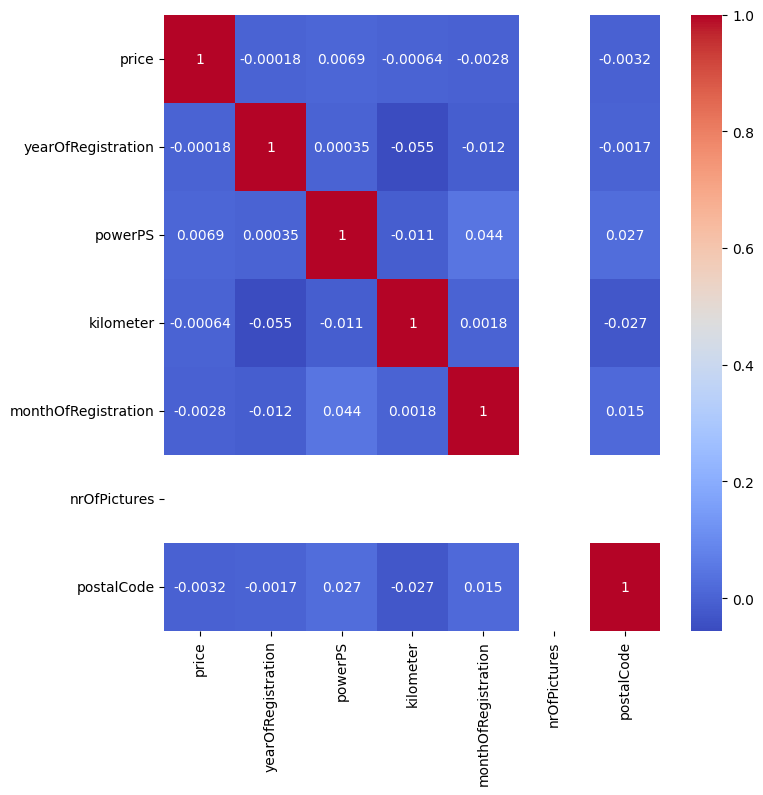

In [112]:
# Alle numerischen Spalten
numeric_columns = car_data.select_dtypes(include=np.number).columns.tolist()
numeric_data = car_data[numeric_columns]

# Generieren eines Korrelationsdiagramms
print('Korrelationsdiagramm:')
correlations = numeric_data.corr()
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', ax=ax)

## Beobachtungen zu den Korrelationen zwischen den Variablen
- **Schwache Korrelationen**: Die beobachteten Korrelationen zwischen den Variablen sind generell sehr schwach. Dies deutet darauf hin, dass keine direkte, starke lineare Beziehung zwischen den gegebenen Merkmalen wie Preis, Baujahr, Leistung und Kilometerstand besteht.

- **Mögliche Datenqualitätsprobleme**: Die Anwesenheit von NaN-Werten in der Korrelationsmatrix, insbesondere bei der Variable nrOfPictures, weist auf mögliche Datenqualitätsprobleme hin.

- **Wichtigkeit der detaillierten Analyse**: Die geringen Korrelationswerte heben die Notwendigkeit hervor, dass eine tiefere, vielleicht sogar modellbasierte Analyse erforderlich sein könnte, um die Faktoren zu identifizieren, die den Preis eines Fahrzeugs beeinflussen.

## Outliers

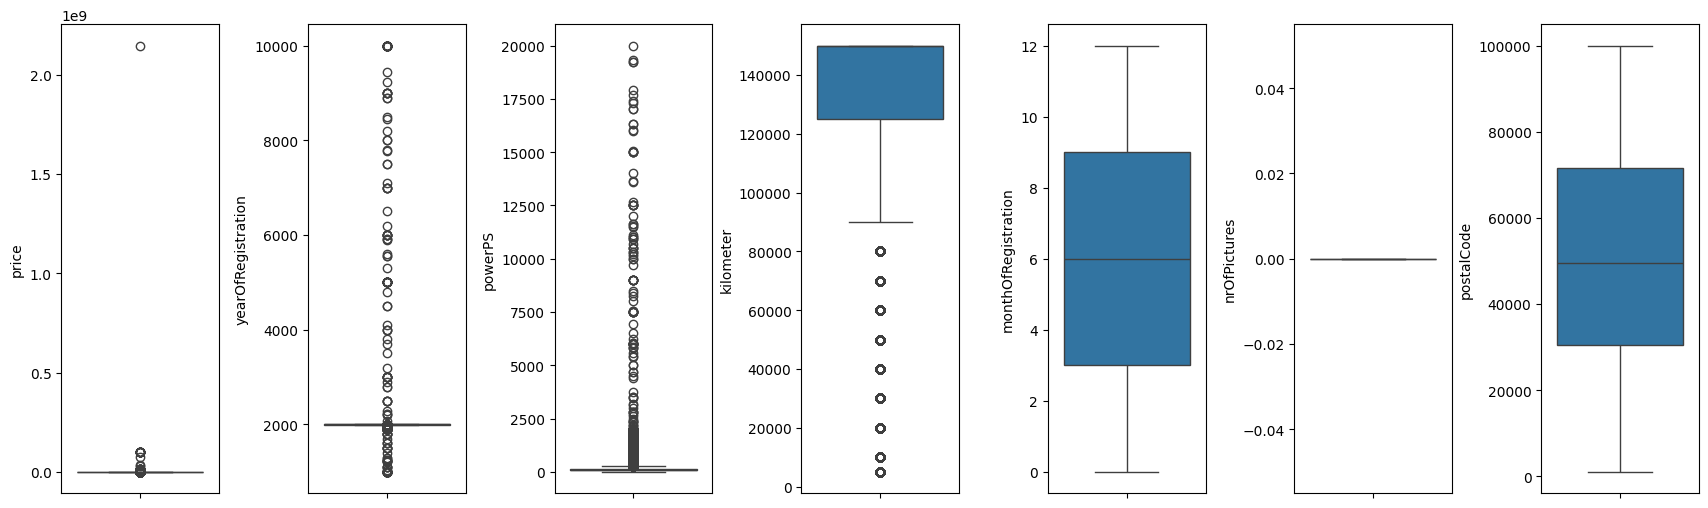

In [113]:
fig, axs = plt.subplots(ncols=7, nrows=1, figsize=(17,5))
index = 0
axs = axs.flatten()
for k, v in numeric_data.items():
    sns.boxplot(y=k, data=numeric_data, ax=axs[index])
    index += 1
plt.tight_layout(pad=.4, w_pad=.5, h_pad=1)

- Hier werden nochmal die Outlier mit Boxplots visualisiert. Die Ergebnisse, die ich oben beschrieben habe, werden hier bestätigt. PostalCode sind richtige deutsche Postleitzahlen.

# 5. Daten Vorverarbeitung

Vor der Modellentwicklung ist eine sorgfältige Vorverarbeitung der Fahrzeugdaten von eBay essentiell. Dieser Prozess umfasst die Bereinigung der Daten von Ausreißern und fehlerhaften Eingaben, das Füllen oder Entfernen fehlender Werte und die Transformation von Kategorien in ein modellverarbeitbares Format. Wir werden ebenfalls neue Merkmale ableiten, die zur Preisprognose beitragen könnten, und sicherstellen, dass unsere Daten ordnungsgemäß skaliert sind. Diese Schritte sind kritisch, um die Qualität der nachfolgenden Analyse und Modellleistung zu gewährleisten.

In [114]:
car_data.drop(columns=['seller', 'offerType', 'abtest', 'nrOfPictures', 'lastSeen', 'dateCrawled', 'dateCreated', 'name', 'normalized_tokens', 'wrongBrand', 'wrongModel', 'wrongMapping'], inplace=True)

In [115]:
price_filter = (car_data['price'].between(0.01, 400000))
year_filter = (car_data['yearOfRegistration'].between(1906, 2016))
power_filter = (car_data['powerPS'].between(MIN_PS, MAX_PS))
month_filter = (car_data['monthOfRegistration'].between(1, 12)) # not used in the end

In [116]:
car_data = car_data[price_filter & year_filter & power_filter]
car_data

,price,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,notRepairedDamage,postalCode,brand,model
1,18300,coupe,2011,manuell,190,125000,5,diesel,ja,66954,audi,a5
2,9800,suv,2004,automatik,163,125000,8,diesel,NaN,90480,jeep,grand
3,1500,kleinwagen,2001,manuell,75,150000,6,benzin,nein,91074,volkswagen,golf
4,3600,kleinwagen,2008,manuell,69,90000,7,diesel,nein,60437,skoda,fabia
5,650,limousine,1995,manuell,102,150000,10,benzin,ja,33775,bmw,316i
...,...,...,...,...,...,...,...,...,...,...,...,...
371520,3200,limousine,2004,manuell,225,150000,5,benzin,ja,96465,turbo,defekt
371524,1199,cabrio,2000,automatik,101,125000,3,benzin,nein,26135,smart,smart
371525,9200,bus,1996,manuell,102,150000,3,diesel,nein,87439,volkswagen,multivan
371526,3400,kombi,2002,manuell,100,150000,6,diesel,NaN,40764,volkswagen,golf


### Handle Brand and Model Columns

In [117]:
top_40_brands = car_data['brand'].value_counts().nlargest(40).index

In [118]:
car_data['brand'] = car_data['brand'].apply(lambda x: x if x in top_40_brands else 'other')

In [119]:
car_data.drop(columns=['model'], inplace=True)

- Die Spalte "brand" wird bearbeitet, um die 40 häufigsten Marken zu behalten und alle anderen Marken in "other" zu gruppieren. Dies ist wichtig, um die Anzahl der Kategorien zu reduzieren und die Modellleistung zu verbessern.
- Die Spalte "model" wird gelöscht wegen der hohen Anzahl an Kategorien und der geringen Qualität der Daten.

### Handle missing data

In [120]:
car_data.isna().sum()

price                      0
vehicleType            11174
yearOfRegistration         0
gearbox                 5518
powerPS                    0
kilometer                  0
monthOfRegistration        0
fuelType               15835
notRepairedDamage      43682
postalCode                 0
brand                      0
dtype: int64

#### notRepairedDamage

In [121]:
car_data['notRepairedDamage'].fillna('unknown', inplace=True)

Grosser Anteil der Daten fehlt. Es ist sicherer die fehlenden Daten mit einer Placeholder Variable zu ersetzen.

#### Gearbox

In [122]:
car_data[car_data['gearbox'].isnull()].shape[0] / nrows * 100

1.4852178032342112

Diese präsentieren nur 1% der Daten. Es ist also möglich, dass diese Zeilen zu imputieren.

In [123]:
mode_gearbox = car_data['gearbox'].mode()[0]
mode_gearbox

'manuell'

In [124]:
car_data['gearbox'].fillna(mode_gearbox, inplace=True)

#### VehicleType

In [125]:
car_data[car_data['vehicleType'].isnull()].shape[0] / nrows * 100

3.0075795094851534

Diese präsentieren nur 3% der Daten. Es ist also möglich, dass diese Zeilen zu imputieren.

In [126]:
mode_vehicleType = car_data['vehicleType'].mode()[0]
mode_vehicleType

'limousine'

In [127]:
car_data['vehicleType'].fillna(mode_vehicleType, inplace=True)

#### FuelType

In [128]:
car_data[car_data['fuelType'].isnull()].shape[0] / nrows * 100

4.262128291811115

Diese präsentieren nur 4% der Daten. Es ist also möglich, dass diese Zeilen zu imputieren.

In [129]:
mode_fuelType = car_data['fuelType'].mode()[0]
mode_fuelType

'benzin'

In [130]:
car_data['fuelType'].fillna(mode_fuelType, inplace=True)

### Train Test Split

In [131]:
X = car_data.drop(columns=['price'])
Y = car_data['price']

In [132]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

- Bei einem umfangreichen Datensatz mit 371.528 Zeilen kann eine einzelne Train-Test-Aufteilung oft ausreichend sein, um die Leistung eines Modells zuverlässig zu bewerten, da sowohl das Trainings- als auch das Testset repräsentativ für die Gesamtpopulation der Daten sein dürften, was die Notwendigkeit einer KFold-Kreuzvalidierung verringert.

- Die Durchführung einer Kreuzvalidierung in einem so großen Datensatz kann zu erheblichen Rechenkosten führen, und wenn die Modellleistung über verschiedene Train-Test-Aufteilungen hinweg stabil ist, bietet eine zusätzliche Kreuzvalidierung möglicherweise keinen bedeutenden Mehrwert für die Beurteilung der Modellgüte.

### Encoding und Scaling der Daten

In [133]:
car_data.head(5)

,price,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,notRepairedDamage,postalCode,brand
1,18300,coupe,2011,manuell,190,125000,5,diesel,ja,66954,audi
2,9800,suv,2004,automatik,163,125000,8,diesel,unknown,90480,jeep
3,1500,kleinwagen,2001,manuell,75,150000,6,benzin,nein,91074,volkswagen
4,3600,kleinwagen,2008,manuell,69,90000,7,diesel,nein,60437,skoda
5,650,limousine,1995,manuell,102,150000,10,benzin,ja,33775,bmw


In [134]:
categorical_features = ['gearbox', 'notRepairedDamage', 'brand', 'vehicleType', 'fuelType']
numeric_features = ['powerPS', 'kilometer', 'yearOfRegistration', 'monthOfRegistration', 'postalCode']

In [135]:
X_train.head()

,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,notRepairedDamage,postalCode,brand
9548,suv,2012,automatik,150,40000,3,benzin,unknown,37534,bmw
207824,bus,2007,automatik,116,60000,5,benzin,nein,47623,volkswagen
62524,kleinwagen,1999,manuell,75,100000,0,benzin,nein,10827,other
267940,kombi,2005,manuell,120,150000,2,diesel,nein,34127,renault
36152,kombi,2002,automatik,133,150000,11,benzin,nein,44534,citroen


In [136]:
# Standardisierung
standard_scaler = StandardScaler()
standard_scaler.fit(X_train[numeric_features])
X_train_ss = pd.DataFrame(standard_scaler.transform(X_train[numeric_features]), columns=numeric_features)
X_test_ss = pd.DataFrame(standard_scaler.transform(X_test[numeric_features]), columns=numeric_features)

In [137]:
# Label Encoding
X_train_le = pd.DataFrame()
X_test_le = pd.DataFrame()

for feature in categorical_features:
    label_encoder = LabelEncoder()
    label_encoder.fit(pd.concat([X_train[feature], X_test[feature]], axis=0))
    X_train_le[feature] = label_encoder.transform(X_train[feature])
    X_test_le[feature] = label_encoder.transform(X_test[feature])

In [138]:
X_train = pd.concat([X_train_ss, X_train_le], axis=1)
X_test = pd.concat([X_test_ss, X_test_le], axis=1)

In [139]:
X_train

,powerPS,kilometer,yearOfRegistration,monthOfRegistration,postalCode,gearbox,notRepairedDamage,brand,vehicleType,fuelType
0,0.318292,-2.163260,1.287579,-0.841319,-0.543804,0,2,3,7,1
1,-0.160416,-1.655924,0.560624,-0.281479,-0.152688,0,1,39,1,1
2,-0.737682,-0.641253,-0.602505,-1.681080,-1.579142,1,1,25,4,1
3,-0.104098,0.627086,0.269841,-1.121240,-0.675881,1,1,29,5,3
4,0.078938,0.627086,-0.166332,1.398043,-0.272438,0,1,6,5,1
...,...,...,...,...,...,...,...,...,...,...
250532,-0.737682,-0.007083,-0.020941,-1.681080,0.003231,1,1,12,6,1
250533,-0.456089,-0.641253,0.560624,0.558282,0.884551,1,1,27,6,1
250534,-0.667284,0.627086,1.869143,-0.841319,0.756156,1,2,25,6,1
250535,-0.160416,0.627086,0.851406,-1.401160,-1.882917,1,1,20,1,1


# 6. Implementierung der Modelle

Wir haben uns entschieden, drei verschiedene Modelle für die Vorhersage der Fahrzeugpreise zu implementieren: Lineare Regression, Random Forest und Gradient Boosting Machines. Die lineare Regression wird als Basis-Modell verwendet, um eine erste Vorstellung von der Beziehung zwischen den Merkmalen und dem Preis zu erhalten. Random Forest wird aufgrund seiner Fähigkeit, nichtlineare Zusammenhänge zu erfassen und Overfitting zu vermeiden, als nächstes eingesetzt. Schließlich nutzen wir Gradient Boosting Machines wegen ihrer hohen Leistungsfähigkeit und Effizienz bei der Handhabung komplexer Datensätze. Diese schrittweise Herangehensweise ermöglicht es uns, die Modelle auf Basis ihrer Vorhersagegenauigkeit und ihrer Fähigkeit, die zugrunde liegenden Muster im Datensatz zu erfassen, zu vergleichen und zu bewerten.

In [140]:
scores = pd.DataFrame(columns=['model', 'mae', 'mse', 'rmse', 'r2'])

In [141]:
# # Linear Regression
from sklearn.linear_model import LinearRegression
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
y_pred_lr = linear_regression.predict(X_test)

# Add score to scores DataFrame
score_lr = pd.DataFrame({'model': ['Linear Regression'], 
                         'mae': [mean_absolute_error(y_test, y_pred_lr)], 
                         'mse': [mean_squared_error(y_test, y_pred_lr)], 
                         'rmse': [np.sqrt(mean_squared_error(y_test, y_pred_lr))],
                         'r2': [r2_score(y_test, y_pred_lr)]})
scores = pd.concat([scores, score_lr], ignore_index=True)

/var/folders/zy/lskfvfbn4sjb60xdtvky2y9w0000gn/T/ipykernel_42578/3825942915.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores = pd.concat([scores, score_lr], ignore_index=True)


In [142]:
score_lr.head()

,model,mae,mse,rmse,r2
0,Linear Regression,3193.890153,43589877.197944,6602.263036,0.450827


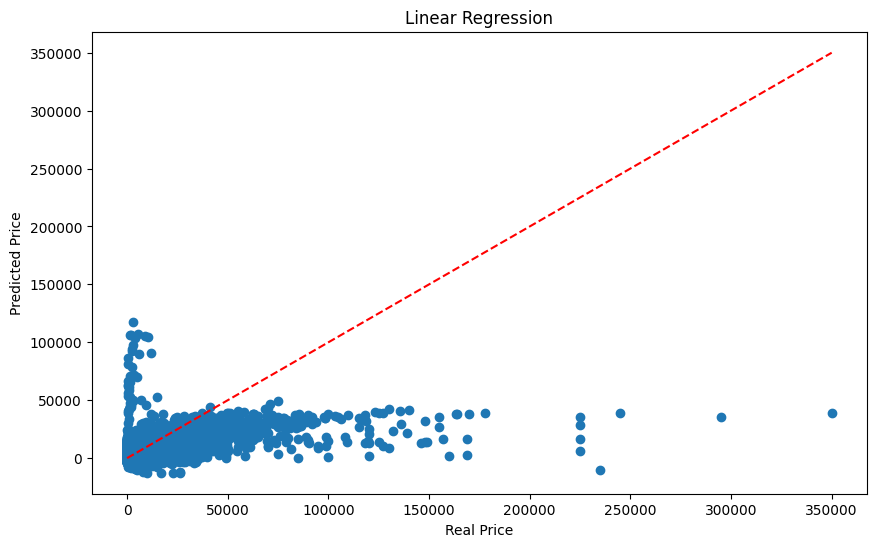

In [143]:
# Visualisierung
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression')
plt.show()

In [144]:
# CatBoost
from catboost import CatBoostRegressor
catboost = CatBoostRegressor(iterations=1000, learning_rate=0.1, random_state=0, verbose=0)
catboost.fit(X_train, y_train)
y_pred_cb = catboost.predict(X_test)

# Metric
score_cb = pd.DataFrame({'model': ['CatBoost'], 
                         'mae': [mean_absolute_error(y_test, y_pred_cb)], 
                         'mse': [mean_squared_error(y_test, y_pred_cb)], 
                         'rmse': [np.sqrt(mean_squared_error(y_test, y_pred_cb))],
                         'r2': [r2_score(y_test, y_pred_cb)]})
scores = pd.concat([scores, score_cb], ignore_index=True)

In [145]:
score_cb.head()

,model,mae,mse,rmse,r2
0,CatBoost,1449.654167,13121271.602911,3622.329582,0.834690


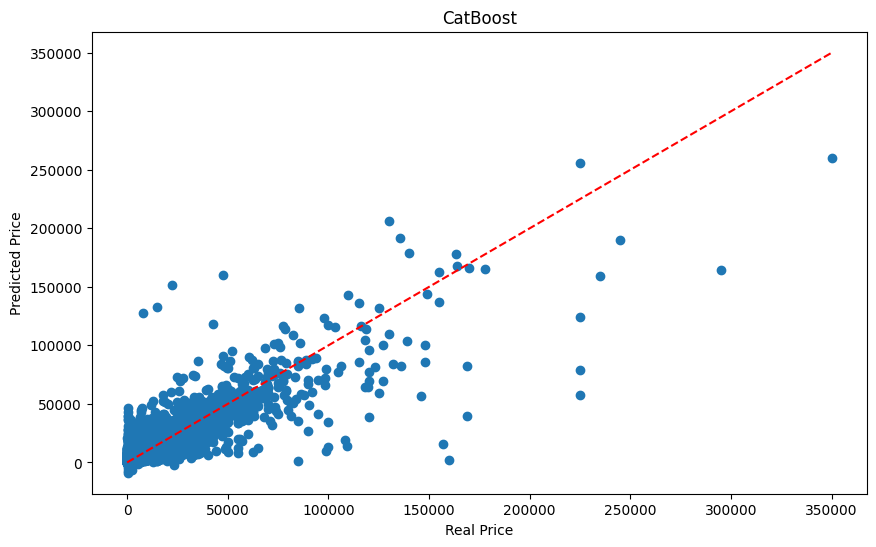

In [146]:
# Visualisierung
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_cb)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.title('CatBoost')
plt.show()

In [147]:
# XGBoost
from xgboost import XGBRegressor
xgboost = XGBRegressor(learning_rate=0.05, random_state=0, verbose=0)
xgboost.fit(X_train, y_train)
y_pred_xg = xgboost.predict(X_test)

# Metric
score_xg = pd.DataFrame({'model': ['XGBRegressor'], 
                         'mae': [mean_absolute_error(y_test, y_pred_xg)], 
                         'mse': [mean_squared_error(y_test, y_pred_xg)], 
                         'rmse': [np.sqrt(mean_squared_error(y_test, y_pred_xg))],
                         'r2': [r2_score(y_test, y_pred_xg)]})
scores = pd.concat([scores, score_xg], ignore_index=True)

/Users/amanai/Desktop/amag_project/venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:51:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [148]:
score_xg.head()

,model,mae,mse,rmse,r2
0,XGBRegressor,1591.723068,16955636.655526,4117.722265,0.786382


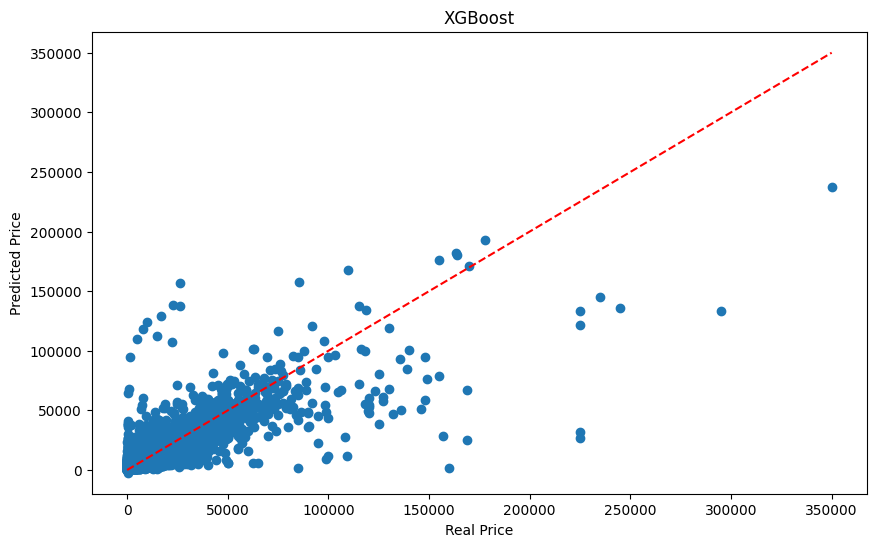

In [149]:
# Visualisierung
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xg)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.title('XGBoost')
plt.show()

# 7. Evaluation der Modelle

Nach der Implementierung der Modelle ist die Bewertung ihrer Leistung anhand von Fehlermetriken entscheidend. Wir werden den Mittleren Absoluten Fehler (MAE), den Mittleren Quadratischen Fehler (MSE) und den Wurzel Mittleren Quadratischen Fehler (RMSE) verwenden, um die Genauigkeit der Preisvorhersagen zu beurteilen. Diese Metriken helfen uns zu verstehen, wie nah die Vorhersagen der Modelle an den tatsächlichen Verkaufspreisen liegen. Zusätzlich werden wir die R²-Werte betrachten, um die Varianz in den Preisen zu bewerten, die durch die Modelle erklärt wird. Anhand dieser Bewertung können wir das beste Modell auswählen und weitere Feinabstimmungen oder Anpassungen vornehmen.

In [150]:
# Scores
scores.head()

,model,mae,mse,rmse,r2
0,Linear Regression,3193.890153,43589877.197944,6602.263036,0.450827
1,CatBoost,1449.654167,13121271.602911,3622.329582,0.834690
2,XGBRegressor,1591.723068,16955636.655526,4117.722265,0.786382


Lineare Regression:

- **MAE**: 3193,89, MSE: 43.589.877,20, RMSE: 6602,26, R²: 0,450827
- **Interpretation**: Das lineare Regressionsmodell weist relativ hohe Fehlermetriken (MAE und RMSE) und einen niedrigen R²-Wert auf. Ein R² von ungefähr 0,45 zeigt an, dass das Modell nur etwa 45% der Varianz der Autopreise erklären kann. Dies ist eine moderate Leistung und deutet darauf hin, dass das Modell möglicherweise zu vereinfacht ist oder wichtige Merkmale fehlen.

CatBoost:

- **MAE**: 1449,65, MSE: 13.121.271,60, RMSE: 3622,33, R²: 0,834690
- **Interpretation**: Das CatBoost-Modell zeigt eine signifikante Verbesserung gegenüber dem linearen Regressionsmodell. Die niedrigeren MAE- und RMSE-Werte deuten auf genauere Vorhersagen hin, und ein R²-Wert von 0,83 legt nahe, dass das Modell etwa 83% der Varianz der Autopreise erklären kann. Dies ist eine starke Leistung und zeigt, dass CatBoost gut zu diesen Daten passt.

XGBRegressor:

- **MAE**: 1591,72, MSE: 16.955.636,66, RMSE: 4117,72, R²: 0,786382
- **Interpretation**: Auch der XGBRegressor leistet gute Arbeit, mit Fehlermetriken und einem R²-Wert, die besser als beim linearen Regressionsmodell sind, aber etwas weniger effektiv als bei CatBoost. Ein R² von ungefähr 0,79 zeigt, dass dieses Modell etwa 79% der Varianz der Autopreise erklären kann.

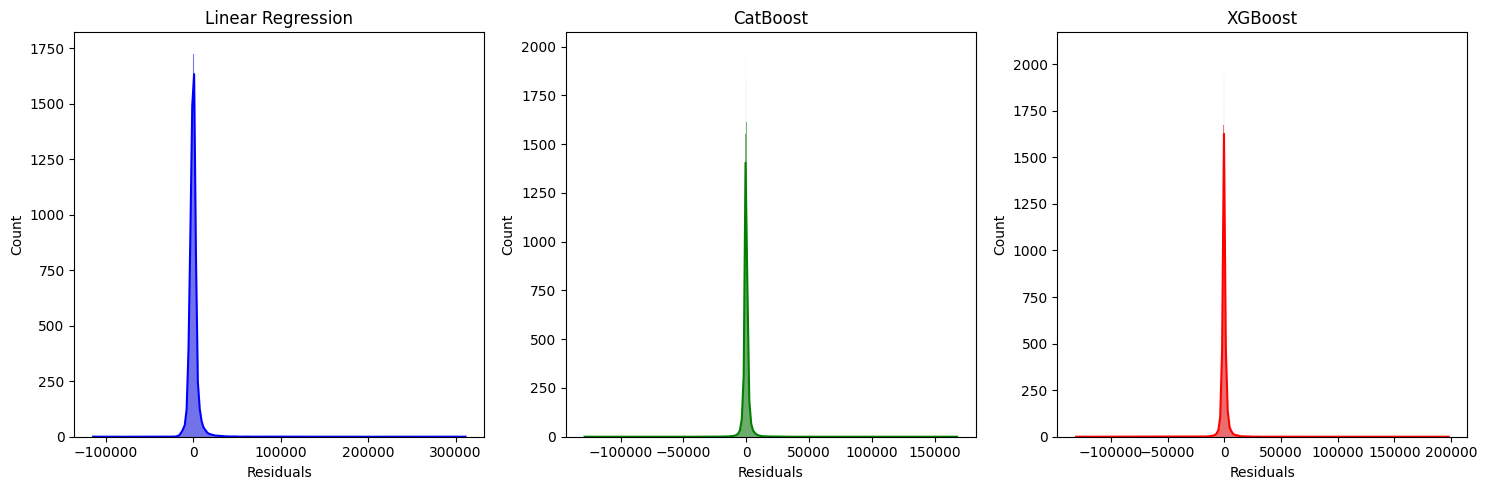

In [151]:
# Calculate residuals for each model
residuals_lr = y_test - y_pred_lr
residuals_cb = y_test - y_pred_cb
residuals_xg = y_test - y_pred_xg

# Plotting residuals
plt.figure(figsize=(15, 5))

# Subplot for Linear Regression
plt.subplot(1, 3, 1)  # 1 row, 3 cols, subplot 1
sns.histplot(residuals_lr, kde=True, color='blue')
plt.title('Linear Regression')
plt.xlabel('Residuals')

# Subplot for CatBoost
plt.subplot(1, 3, 2)  # 1 row, 3 cols, subplot 2
sns.histplot(residuals_cb, kde=True, color='green')
plt.title('CatBoost')
plt.xlabel('Residuals')

# Subplot for XGBoost
plt.subplot(1, 3, 3)  # 1 row, 3 cols, subplot 3
sns.histplot(residuals_xg, kde=True, color='red')
plt.title('XGBoost')
plt.xlabel('Residuals')

plt.tight_layout()
plt.show()

- Die Residuenverteilung des linearen Regressionsmodells zeigt eine breite Streuung, was auf eine mögliche Untererfassung der Komplexität im Datensatz hindeutet, da die Residuen sich über einen weiten Bereich erstrecken.

- Die Residuen der CatBoost- und XGBoost-Modelle sind enger um den Nullpunkt konzentriert und deutlich schmaler, was auf eine bessere Modellanpassung und genauere Vorhersagen hinweist als bei der linearen Regression.

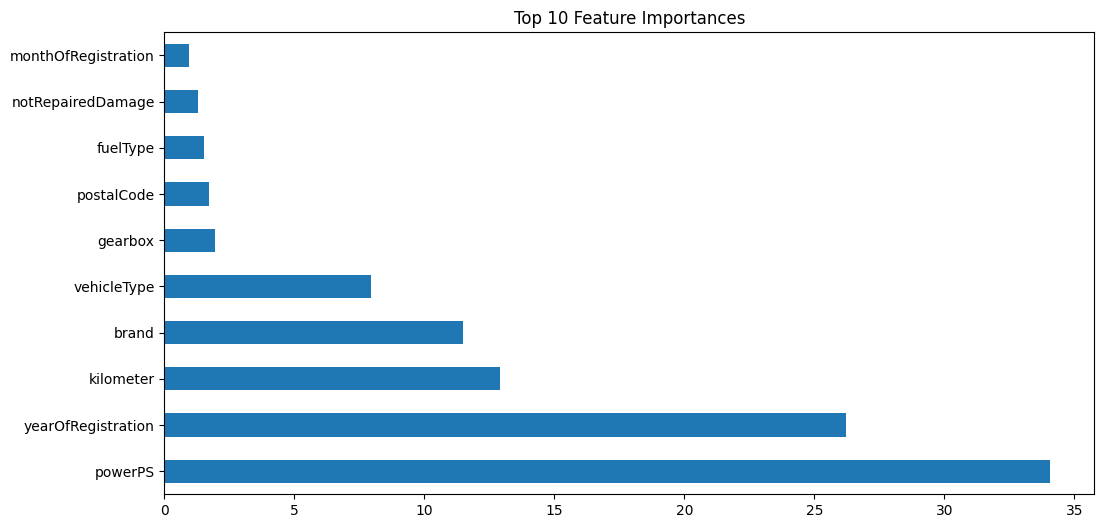

In [152]:
feature_importances = pd.Series(catboost.feature_importances_, index=X_train.columns)

plt.figure(figsize=(12, 6))
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.show()

- Starke Wichtigkeit: Kilometer, PowerPS, yearOfRegistration

## 8. Frage: Auf was muss man achten, wenn man ein solches Prognosemodell in Produktion nehmen möchte?

1. **Modellleistung und Generalisierung**: Vor dem Einsatz eines Modells muss sichergestellt werden, dass es gut auf unbekannte Daten funktioniert. Dies beinhaltet eine strenge Validierung mit Techniken wie Kreuzvalidierung. Das Modell sollte gut generalisieren, das heißt, es sollte nicht nur auf den Daten, auf denen es trainiert wurde, sondern auch auf neuen, unbekannten Daten genaue Vorhersagen treffen.

2. **Interpretierbarkeit und Erklärbarkeit des Modells**: Es ist wichtig zu verstehen, warum Ihr Modell bestimmte Vorhersagen macht. Dies ist besonders in Bereichen wichtig, in denen Vertrauen und Transparenz erforderlich sind. Techniken wie die Wichtigkeit von Merkmalen helfen zu verstehen, welchen Einfluss verschiedene Variablen auf die Vorhersagen haben.

3. **Datenpipeline und Modell-Eingaben**: Für den Einsatz eines Modells in der Produktion muss die Datenpipeline, die das Modell speist, robust sein. Die Daten, die in der Produktion für Vorhersagen verwendet werden, müssen genauso vorverarbeitet und bereinigt werden wie die Trainingsdaten.

4. **Überwachung und Wartung**: Nach dem Einsatz sollte die Leistung des Modells kontinuierlich anhand von Daten aus der realen Welt überwacht werden. Dies beinhaltet auch, das Modell regelmäßig mit neuen Daten zu aktualisieren, um eine Modellverzerrung zu verhindern, die auftritt, wenn sich die Muster in den Daten mit der Zeit ändern.

5. **Skalierbarkeit**: Das Modell muss in der Lage sein, den Umfang der Produktionsdaten und -anfragen zu bewältigen. Dies kann die Optimierung des Modells für Leistung, die Sicherstellung, dass die Infrastruktur die Last bewältigen kann, und die Skalierbarkeit des Modells bei Bedarf beinhalten.

6. **Compliance und Sicherheit**: Stellen Sie sicher, dass das Modell allen relevanten Datenschutzgesetzen und Branchenvorschriften entspricht. Die Sicherheit der vom Modell verwendeten Daten, insbesondere wenn es sich um persönliche Informationen handelt, ist von größter Bedeutung.

7. **Fehlerbehandlung und Robustheit**: Das System sollte in der Lage sein, unerwartete Daten oder Fehler elegant zu handhaben. Dies beinhaltet Strategien für den Fall, dass das Modell ausfällt oder unsichere Vorhersagen liefert.

8. **Kosten**: Berücksichtigen Sie die Kosten für den Betrieb des Modells in der Produktion. Dies umfasst Rechenressourcen, Speicher und mögliche Skalierungskosten.

Jeder dieser Aspekte erfordert sorgfältige Planung und Ausführung, um den erfolgreichen Einsatz und Betrieb eines Prognosemodells in einer Produktionsumgebung sicherzustellen.

# 9. Schlussfolgerung

- Unser umfassender Ansatz zur Datenbereinigung und -analyse hat es uns ermöglicht, wertvolle Einblicke in den Gebrauchtwagenmarkt zu gewinnen und zuverlässige Vorhersagen zu den Fahrzeugpreisen zu machen, was Käufern und Verkäufern hilft, informierte Entscheidungen zu treffen.

- Durch die Anwendung fortschrittlicher maschineller Lernmodelle konnten wir die Leistung der linearen Regression übertreffen und mit CatBoost und XGBoost eine hohe Erklärungskraft der Varianz in den Fahrzeugpreisen erreichen.

- Die intensive explorative Datenanalyse (EDA) und die nachfolgende Datenbereinigung haben sich als entscheidende Schritte erwiesen, um die Datenqualität für das Training der Modelle sicherzustellen und die Modellgenauigkeit zu optimieren.

- Die Feature-Importance-Analyse hat wichtige Variablen hervorgehoben, die den Preis eines Fahrzeugs beeinflussen, und bietet Einsichten, die für die Verbesserung und das Feintuning des Prognosemodells genutzt werden können.

- Abschließend haben wir wichtige Überlegungen diskutiert, die zu beachten sind, wenn ein Prognosemodell in eine Produktionsumgebung überführt wird, einschließlich der Generalisierung des Modells, der Interpretierbarkeit der Modellergebnisse und der kontinuierlichen Überwachung und Wartung des Modells.